In [2]:
import gspread
from google.oauth2.service_account import Credentials
import datetime
import pandas as pd
import numpy as np
from itertools import combinations


In [3]:
CREDENTIALS_FILENAME = "nodal-wall-416914-5876acf16f70.json"
BEO_WORKSHEET_ID = 2121169814
KIMITTUD_WORKSHEET_ID = 858480548
MASTER_SHEET_ID = "1fwhZxPtuP2MSBkTXJRSH-plXGV42mF-HlQPf4KSpFwE"

In [4]:
def initialize_gspread(service_account_file_path: str):
    credentials = Credentials.from_service_account_file(
        service_account_file_path,
        scopes=["https://www.googleapis.com/auth/spreadsheets"],
    )
    return gspread.authorize(credentials)

def sheet_to_df(sheet: gspread.Spreadsheet, worksheet_id: int | str):
    data = sheet.get_worksheet_by_id(worksheet_id).get_values()
    return pd.DataFrame(data[1:], columns=data[0])

def download_data():
    gc = initialize_gspread(CREDENTIALS_FILENAME)
    sheet = gc.open_by_key(MASTER_SHEET_ID)
    beo_df = sheet_to_df(sheet, BEO_WORKSHEET_ID)
    kimittud_df = sheet_to_df(sheet, KIMITTUD_WORKSHEET_ID)
    return beo_df, kimittud_df

In [5]:
beo_df, kimittud_df = download_data()

In [37]:
kimittud_df.columns

Index(['Hot shit?', 'HIÁNY', 'JÁTÉK', 'Co-op', 'Gyerek', 'Heavy', 'Kétfős',
       'Nyelvfüggetlen', 'Party', 'Szélproof', 'ÁDÁM', 'ALEX', 'BALU', 'BELLA',
       'BORCSA', 'BORI', 'DÁVID', 'DORINA', 'DORKA', 'EMMA', 'FANNI', 'GERGŐ',
       'JANKA', 'KATA', 'KRISTÓF', 'LILLA', 'MÁRK', 'NIKI', 'PANKA', 'RÉKA',
       'SANYI', 'SÁRI', 'TAKI', 'VANDA', 'VERONKA', 'SP', 'ROSI', 'KINGA',
       'I.ORSI', '!!!'],
      dtype='object')

In [6]:
def cleanup_beo_df(
    beo_df: pd.DataFrame,
    max_days_past: int = 100,
    day_of_event: datetime = datetime.datetime.today(),
):
    filtered = beo_df.drop(beo_df.columns[[1, 2, -1, -2, -3, -4, -5]], axis=1)
    filtered.drop([0, 1, 2], inplace=True)

    day_of_event = datetime.datetime.today()
    min_date = day_of_event - datetime.timedelta(days=max_days_past)

    filtered["Dátum"] = pd.to_datetime(filtered["Dátum"], format="%Y.%m.%d.")

    filtered = filtered.loc[
        (filtered["Dátum"] > min_date) & (filtered["Dátum"] < day_of_event)
    ]

    filtered["days_before"] = (day_of_event - filtered["Dátum"]).dt.days

    filtered.set_index("Dátum", inplace=True)

    return filtered


cleaned_beo = cleanup_beo_df(beo_df)

In [41]:
def clean_kimittud_df(kimittud_df: pd.DataFrame, count_of_retired_gms: int = 4):
    df = kimittud_df.copy()
    df.drop(df.columns[[0, 1, 3, 4, 5, 6, 7, 8, 9, -1]], axis=1, inplace=True)
    # delete empty rows based on the last value of column 'ÁDÁM':
    column_to_check = "ÁDÁM"
    df.replace("", np.nan, inplace=True)
    df.dropna(subset=column_to_check, inplace=True)

    df.drop(df.columns[-count_of_retired_gms:], axis=1, inplace=True)

    df.drop([0,1], inplace=True)

    df.iloc[:, 1:] = df.iloc[:, 1:].apply(lambda x: x == "2")
    df[df.columns[1:]] = df[df.columns[1:]].astype("bool")

    return df

In [42]:
clean_kimittud_df(kimittud_df).dtypes

JÁTÉK      object
ÁDÁM         bool
ALEX         bool
BALU         bool
BELLA        bool
BORCSA       bool
BORI         bool
DÁVID        bool
DORINA       bool
DORKA        bool
EMMA         bool
FANNI        bool
GERGŐ        bool
JANKA        bool
KATA         bool
KRISTÓF      bool
LILLA        bool
MÁRK         bool
NIKI         bool
PANKA        bool
RÉKA         bool
SANYI        bool
SÁRI         bool
TAKI         bool
VANDA        bool
VERONKA      bool
dtype: object

In [48]:


# input: (number of gamemasters for the event, list of gamemasters applying for an event)
def GenerateMasterDatabase(
    number_of_gamemasters: int,
    list_of_applicants: list[str],
    cleaned_kimittud_df: pd.DataFrame,
    threshhold_percent: int = 57,
):

    dict_of_results = {}
    
    
    min_gm_count_for_game = round(number_of_gamemasters * threshhold_percent / 100)

    combination_list_of_gamemasters = list(
        combinations(list_of_applicants, number_of_gamemasters)
    )

    # todo optimize this with pandas magic
    for comb in combination_list_of_gamemasters:
        list_of_games_over_threshhold = []
        comb_evaluation_dataframe = pd.DataFrame()

        for i in range(number_of_gamemasters):
            comb_evaluation_dataframe[comb[i]] = cleaned_kimittud_df[comb[i]]

        for j in range(len(comb_evaluation_dataframe)):
            count_of_gms_who_know_the_game = 0

            for k in range(number_of_gamemasters):
                if comb_evaluation_dataframe.iloc[j, k]:
                    count_of_gms_who_know_the_game += 1

            if count_of_gms_who_know_the_game > min_gm_count_for_game:
                list_of_games_over_threshhold.append(
                    str(j) + " - " + str(cleaned_kimittud_df.iloc[j, 0])
                )
        dict_of_results[comb] = (
            len(list_of_games_over_threshhold),
            list_of_games_over_threshhold,
        )

    return dict_of_results

In [49]:
list_of_applicants = [
    "ÁDÁM",
    "ALEX",
    "BALU",
    "BELLA",
    "BORCSA",
    "BORI",
    "DÁVID",
    "DORINA",
    "DORKA",
    "EMMA",
]

GenerateMasterDatabase(6, list_of_applicants, clean_kimittud_df(kimittud_df))

                                                ÁDÁM  \
                                                ALEX   
                                                BALU   
                                               BELLA   
                                              BORCSA   
                                                BORI   
0                                                124   
1  [0 - 20 másodperc totál káosz, 1 - 7 Csoda, 2 ...   

                                                      \
                                                       
                                                       
                                                       
                                                       
                                               DÁVID   
0                                                123   
1  [0 - 20 másodperc totál káosz, 1 - 7 Csoda, 2 ...   

                                                      \
                                              

{('ÁDÁM', 'ALEX', 'BALU', 'BELLA', 'BORCSA', 'BORI'): (124,
  ['0 - 20 másodperc totál káosz',
   '1 - 7 Csoda',
   '2 - 7 Csoda Párbaj',
   '4 - 8 perces birodalom',
   '11 - Ab in die tonne',
   '15 - Álarcosbál/Mascarade',
   '16 - Allűr',
   '17 - Álmodj hát!',
   '18 - Álmodj velem',
   '21 - Avalon',
   '22 - Azul',
   '23 - Azul: A királyi pavilon',
   '25 - Azul: Sintra üvegcsodái',
   '26 - Bal jobb',
   '28 - Battlesheep',
   '30 - Between Two Cities',
   '31 - Bison',
   '32 - Block Out',
   '35 - Canvas',
   '37 - Carcassonne',
   '38 - Cascadia',
   "39 - Cash'n'Guns",
   '41 - Cat Lady',
   '43 - Century 1: Fűszerút',
   '48 - Cica pizza taco gida sajt',
   '49 - Coloretto',
   '50 - Concept',
   '52 - Copenhagen',
   '54 - Crossing',
   '55 - Cryptid',
   '57 - Csak egy',
   '58 - Csaló molyok',
   '59 - Csordaszellem',
   '60 - Csótányleves',
   '61 - Csótánypóker ',
   '62 - Csótánypóker Royal',
   '63 - Csúszkaland',
   '65 - Deszkalózok',
   '66 - Diamant (Gyémántvad

In [50]:
cleaned_beo

,ÁDÁM,ALEX,BALU,BELLA,BORCSA,BORI,DÁVID,DORINA,DORKA,EMMA,...,MÁRK,NIKI,PANKA,RÉKA,SANYI,SÁRI,TAKI,VANDA,VERONKA,days_before
Dátum,,,,,,,,,,,,,,,,,,,,,
2024-01-22,,,oj,,j,,,,,,...,,,,,jv,,bj,,o,99
2024-01-29,jv,,,,,j,oj,,,v,...,,,,,v,,oj,,o,92
2024-02-01,,,,,,,,,,j,...,,,,,,,jk,,,89
2024-02-05,,j,,,,,,,,,...,oj,,,,,,oj,jv,o,85
2024-02-15,,,oj,,b,j,,,,,...,bo,,v,jv,,,,,o,75
2024-02-19,,,oj,,,,,,,ve,...,,,,jv,,,,,o,71
2024-02-26,,,,j,,,v,,,,...,o,,,jv,,,oj,j,,64
2024-03-11,jv,,oj,,,jv,,,,,...,,b,,,v,,,,o,50
2024-03-12,,,,,,,ojv,,,,...,,,,,,,oj,,,49


In [51]:
def calc_beo_weight(days_before: int):
    if days_before == 0:
        return 1
    return np.max([0, 1 - 0.5 * np.log(days_before)])

In [52]:
weigths = pd.Series()

for name, values in cleaned_beo.items():
    if values.dtype != np.dtypes.StrDType:
        continue
    weight = cleaned_beo.apply(lambda r: calc_beo_weight(r["days_before"]) if "j" in r[name] else 0, axis=1).sum()
    weigths[name] = weight

weigths

ÁDÁM       0.000000
ALEX       1.000000
BALU       0.000000
BELLA      1.000000
BORCSA     0.000000
BORI       1.195281
DÁVID      1.000000
DORINA     0.000000
DORKA      0.000000
EMMA       0.027045
FANNI      0.000000
GERGŐ      0.000000
JANKA      0.000000
KATA       0.000000
KRISTÓF    0.000000
LILLA      0.222326
MÁRK       0.000000
NIKI       0.195281
PANKA      0.000000
RÉKA       1.195281
SANYI      0.000000
SÁRI       0.000000
TAKI       1.000000
VANDA      0.000000
VERONKA    0.000000
dtype: float64

<Axes: >

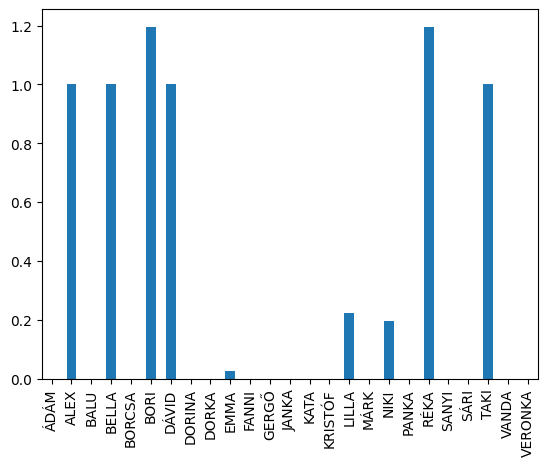

In [53]:
import matplotlib.pyplot as plt

weigths.plot(kind="bar")